LSTM
==

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# import numpy as np
from random import shuffle

In [2]:
filename= '../data/french_clean.txt'

In [50]:
def reverse_sequence(nouns):
    return [noun[::-1] for noun in nouns]

def pad_sequence(sequence:str,pad_size,pad_token):
    # returns a list of the characters in the sequence with additional pad tokens to match pad_size if needed
    return list(sequence) + [pad_token] * (pad_size - len(sequence))

def code_sequence(charseq,encodingmap,unk_token='<unk>'):
    # charseq is a sequence of chars
    return [encodingmap[char] if char in encodingmap 
            else encodingmap[unk_token] for char in charseq]

def decode_sequence(idxseq,decodingmap):
    # idxseq is a list of integers
    return [decodingmap[idx] for idx in idxseq]

In [12]:
def read_data(filename, reverse_nouns=False):
    with open(filename, 'r', encoding='utf-8') as file:
        data = [line.strip() for line in file.readlines()]

    X, y = [], []
    for pair in data:
        noun, gender = pair.split(', ')
        if reverse_nouns:
            noun = reverse_sequence(noun)
        X.append(noun)
        y.append(gender)
    
    return X, y

In [29]:
def vocabulary(filename, labels=False, pad_token='<pad>', unk_token='<unk>'):
    
    nouns, genders = read_data(filename, reverse_nouns=False)
    
    if labels:
        sym2idx = {sym: idx for idx, sym in enumerate(set(genders))}
    else:
        noun_chars = set(char for noun in nouns for char in noun) # split the nouns into characters
        sym2idx = {sym: idx for idx, sym in enumerate(noun_chars)}
        sym2idx[unk_token] = len(sym2idx)
        sym2idx[pad_token] = len(sym2idx)

    idx2sym = {idx: sym for sym, idx in sym2idx.items()}

    return idx2sym, sym2idx

In [37]:
print('a' + '<pad>')

a<pad>


In [49]:
# nouns = ['abandonnataire', 'abélite', 'abkhaze', 'ablon', 'abolitioniste', 'abolitionniste', 'aborigène']
# noun_chars = set(char for noun in nouns for char in noun)

# pad_size = max(len(noun) for noun in nouns)
# print(pad_size)
# for noun in nouns:
#     padded_seq = pad_sequence(noun,pad_size,'<pad>')
#     print(padded_seq)
#     print(len(padded_seq))

14
['a', 'b', 'a', 'n', 'd', 'o', 'n', 'n', 'a', 't', 'a', 'i', 'r', 'e']
14
['a', 'b', 'é', 'l', 'i', 't', 'e', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
14
['a', 'b', 'k', 'h', 'a', 'z', 'e', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
14
['a', 'b', 'l', 'o', 'n', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
14
['a', 'b', 'o', 'l', 'i', 't', 'i', 'o', 'n', 'i', 's', 't', 'e', '<pad>']
14
['a', 'b', 'o', 'l', 'i', 't', 'i', 'o', 'n', 'n', 'i', 's', 't', 'e']
14
['a', 'b', 'o', 'r', 'i', 'g', 'è', 'n', 'e', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
14


In [30]:
# Author: Benoit Crabbé (with slight modifications)
class DataGenerator:

      def __init__(self, filename, reverse_nouns=False, pad_token='<pad>', unk_token='<unk>'):

          self.pad_token = pad_token
          self.unk_token = unk_token

          self.input_idx2sym,self.input_sym2idx   = vocabulary(filename,False)
          self.output_idx2sym,self.output_sym2idx = vocabulary(filename,True)

          nouns, genders = read_data(filename, reverse_nouns=reverse_nouns)
          self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(nouns, genders, test_size=0.2)

      def generate_batches(self,batch_size,validation=False):

          if validation:
              X = self.X_test
              y = self.y_test
          else:
              X = self.X_train
              y = self.y_train

          assert(len(X) == len(y))

          N     = len(X)
          idxes = list(range(N))

          # Data ordering
          shuffle(idxes)
          idxes.sort(key=lambda idx: len(X[idx]))

          # batch generation
          bstart = 0
          while bstart < N:
              bend        = min(bstart+batch_size,N)
              batch_idxes = idxes[bstart:bend]
              batch_len   = max(len(X[idx]) for idx in batch_idxes)
              Xpad        = [pad_sequence(X[idx],batch_len,self.pad_token) for idx in batch_idxes]
              seqX        = [code_sequence(x,self.input_sym2idx,self.unk_token) for x in Xpad]
              seqY        = [self.output_sym2idx[y[idx]] for idx in batch_idxes]

              assert(len(seqX) == len(seqY))
              yield (seqX,seqY)
              bstart += batch_size

Model
==

Train the model by feeding it words in reverse order (since we want to start from the end of the word) and the corresponding genders. The model will learn to predict the gender based on the characters seen so far.

Takes preprocessed words as input:
- tokenized into characters 
- each character mapped to a unique integer id (same with each gender)
- sequences should be padded so they all have the same length

In [113]:
class GenderLSTM(nn.Module):
    def __init__(self, datagenerator, embedding_dim, hidden_dim, device='cpu'):
        super(GenderLSTM, self).__init__()
        self.to(device)

        invocab_size = len(datagenerator.input_idx2sym)
        outvocab_size = len(datagenerator.output_idx2sym)

        self.device = torch.device(device)
        self.pad_idx = datagenerator.input_sym2idx[datagenerator.pad_token]
        self.embedding = nn.Embedding(invocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, outvocab_size)
        # self.softmax = nn.Softmax(dim=-1)

        for param in self.parameters():
            param.requires_grad = True

    def forward(self, inputs):
        embeds = self.embedding(inputs)
        lstm_out, _ = self.lstm(embeds)
        logits = self.fc(lstm_out)   # shape: (batch_size, sequence_length, num_classes) 
        # add softmax to get probability distributions
        # distributions = self.softmax(logits)   # probability distribution over the classes for each character in the sequence
        # it would also be a good idea to calibrate the model (dividing c by a value T (tempreture) that is a hyperparameter that can be tuned --> ask Timothee)
        return logits  

    def train_model(self, datagenerator, n_epochs, batch_size, learning_rate=0.001):
        criterion = nn.CrossEntropyLoss(ignore_index=self.pad_idx)
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        self.all_train_max_indecies = []
        self.all_dev_max_indecies = []
        
        self.avg_train_accuracies = []
        self.avg_valid_accuracies = []
        self.avg_valid_losses = []
        
        for epoch in range(n_epochs):
            print(f'Epoch: {epoch}')
            batch_train_losses = []
            batch_train_accuracies = []

            batch_dev_losses = []
            batch_dev_accuracies = []
            
            self.train()
            for inputs, labels in datagenerator.generate_batches(batch_size):
                X = torch.LongTensor(inputs).to(self.device)
                Y = torch.LongTensor(labels).to(self.device) # shape: (batch_size)

                optimizer.zero_grad()
                Y_logits = self.forward(X)    # shape: (batch_size, sequence_length, num_classes)

                char_position_accuracies = []    # list to store the accurracies for each character position in each word
                char_position_losses = []

                for char_position in range(Y_logits.size(1)):    # Y_distributions.size(1) = sequence_length
                    Y_logit_char_pos = Y_logits[:, char_position, :]    # Shape: (batch_size, num_classes)
                    Y_pred_char_pos = torch.argmax(Y_logit_char_pos, dim=-1)    # Shape: (batch_size)
                    
                    # compute accuracy for the current position
                    mask = (Y != self.pad_idx) # creates a binary mask where positions with padding tokens are set to False, and non-padding positions are set to True
                    correct_char_pos = torch.sum((Y_pred_char_pos == Y) * mask)   # calculates the number of correct predictions at the specific character position, considering only non-padding positions
                    total_char_pos = torch.sum(mask)    # calculates the total number of "non-padding" positions at the specific character position.
                    char_position_accuracy = float(correct_char_pos) / float(total_char_pos) # computes the accuracy at the specific character position, considering only non-padding positions 
                    char_position_accuracies.append(char_position_accuracy)

                    # compute the loss for the current position
                    char_position_loss = criterion(Y_logit_char_pos, Y)
                    char_position_losses.append(char_position_loss.item())

                # getting the index (character position) and accuracy of the character with the highest accuracy for each word (I don't know if different word lengths will create a problem in interpretation here)
                max_accuracy, max_index = torch.max(torch.tensor(char_position_accuracies), dim=0)
                batch_train_accuracies.append(max_accuracy.item())
                self.all_train_max_indecies.append(max_index.item())

                # NOTE: currently, I'm using the average of the losses of all characters in the sequence as the loss for that sequence; but for the accuracy, I'm using that of the character which had the highest accuracy. 
                # loss = sum(char_position_losses) / len(char_position_losses)
                loss = torch.mean(torch.tensor(char_position_losses, requires_grad=True))
                loss.backward()

                # Check gradients
                # for param in self.parameters():
                #     print(param.grad)

                optimizer.step()
                batch_train_losses.append(loss.item())

            self.eval()
            for val_inputs, val_labels in datagenerator.generate_batches(batch_size, validation=True):
                with torch.no_grad():
                    X_val = torch.LongTensor(val_inputs).to(self.device)
                    Y_val = torch.LongTensor(val_labels).to(self.device)

                    Y_val_logits = self.forward(X_val)
                    val_char_position_accuracies = []
                    val_char_position_losses = []

                    for char_position in range(Y_val_logits.size(1)):
                        Y_logit_char_pos = Y_val_logits[:, char_position, :]    # Shape: (batch_size, num_classes)
                        Y_pred_char_pos = torch.argmax(Y_logit_char_pos, dim=-1)    # Shape: (batch_size)
                        
                        # compute accuracy for the current position
                        mask = (Y_val != self.pad_idx)
                        correct_char_pos = torch.sum((Y_pred_char_pos == Y_val) * mask)
                        total_char_pos = torch.sum(mask)
                        char_position_accuracy = float(correct_char_pos) / float(total_char_pos) 
                        val_char_position_accuracies.append(char_position_accuracy)

                        # compute the loss for the current position
                        char_position_loss = criterion(Y_logit_char_pos, Y_val)
                        val_char_position_losses.append(char_position_loss.item())

                    # getting the index (character position) and accuracy of the character with the highest accuracy for each word (I don't know if different word lengths will create a problem in interpretation here)
                    max_accuracy, max_index = torch.max(torch.tensor(val_char_position_accuracies), dim=0)
                    batch_dev_accuracies.append(max_accuracy.item())
                    self.all_dev_max_indecies.append(max_index.item())

                    # NOTE: currently, I'm using the average of the losses of all characters in the sequence as the loss for that sequence; but for the accuracy, I'm using that of the character which had the highest accuracy. 
                    loss = torch.mean(torch.tensor(val_char_position_losses, requires_grad=False))
                    batch_dev_losses.append(loss.item())


            # store & report metrics at the end of each epoch
            avg_train_loss = sum(batch_train_losses) / len(batch_train_losses)
            avg_train_acc = sum(batch_train_accuracies) / len(batch_train_accuracies)
            avg_dev_loss = sum(batch_dev_losses) / len(batch_dev_losses)
            avg_dev_acc = sum(batch_dev_accuracies) / len(batch_dev_accuracies)

            self.avg_train_accuracies.append(avg_train_acc)
            self.avg_valid_accuracies.append(avg_dev_acc)
            self.avg_valid_losses.append(avg_dev_loss)

            print(f'Train Loss: {avg_train_loss * 100:.2f}%')
            print(f'Train Accuracy: {avg_train_acc * 100:.2f}%')        
            print(f'Valid Loss: {avg_dev_loss * 100:.2f}%')
            print(f'Valid Accuracy: {avg_dev_acc * 100:.2f}%')
            print('-' * 100)


    def predict(self, datagenerator, batch_size):
        # TODO
        ...


In [137]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_dim = 64
hidden_dim = 128
n_epochs = 10
batch_size = 32

data_generator = DataGenerator(filename, reverse_nouns=True)
model = GenderLSTM(data_generator, embedding_dim, hidden_dim, device=DEVICE)
model.train_model(data_generator, n_epochs, batch_size)

Epoch: 0
Train Loss: 68.96%
Train Accuracy: 64.73%
Valid Loss: 68.92%
Valid Accuracy: 65.16%
----------------------------------------------------------------------------------------------------
Epoch: 1
Train Loss: 68.96%
Train Accuracy: 64.74%
Valid Loss: 68.91%
Valid Accuracy: 64.73%
----------------------------------------------------------------------------------------------------
Epoch: 2
Train Loss: 68.96%
Train Accuracy: 64.73%
Valid Loss: 68.91%
Valid Accuracy: 65.20%
----------------------------------------------------------------------------------------------------
Epoch: 3
Train Loss: 68.96%
Train Accuracy: 64.80%
Valid Loss: 68.92%
Valid Accuracy: 64.66%
----------------------------------------------------------------------------------------------------
Epoch: 4
Train Loss: 68.96%
Train Accuracy: 64.75%
Valid Loss: 68.91%
Valid Accuracy: 64.93%
----------------------------------------------------------------------------------------------------
Epoch: 5
Train Loss: 68.96%
Tr

In [139]:
import matplotlib.pyplot as plt

def plot1(train_acc, valid_acc, valid_losses):

    x_axis = range(1, len(valid_losses) + 1)

    plt.plot(x_axis ,train_acc, marker='o', label='Training Accuracies')
    plt.plot(x_axis, valid_acc, marker='o', label='Validation Accuracies')
    plt.plot(x_axis, valid_losses, marker='o', label='Loss')

    plt.title('Loss & Accuracy Evolution Over Epochs')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid(True, linestyle='--')
    plt.show()

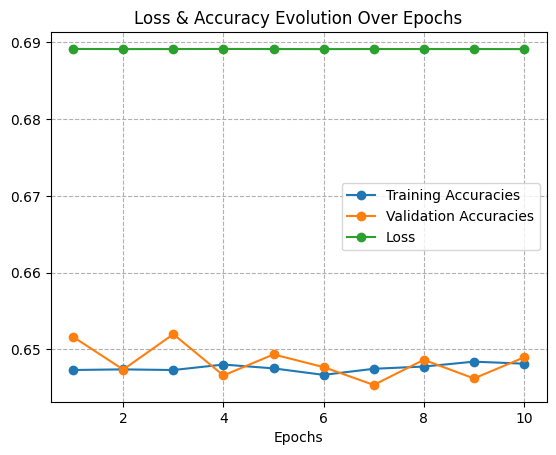

In [140]:
plot1(model.avg_train_accuracies, model.avg_valid_accuracies, model.avg_valid_losses)

In [141]:
import matplotlib.pyplot as plt

def plot2(train_acc, valid_acc, valid_losses, train_max_indices, dev_max_indices):

    # Plotting Accuracy and Loss
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    x_axis = range(1, len(valid_losses) + 1)

    ax1.plot(x_axis, train_acc, marker='o', label='Training Accuracies')
    ax1.plot(x_axis, valid_acc, marker='o', label='Validation Accuracies')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, linestyle='--')

    ax2.plot(x_axis, valid_losses, marker='o', label='Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, linestyle='--')

    # Plotting max indices
    fig, (ax3, ax4) = plt.subplots(2, 1, figsize=(16, 8))

    ax3.set_title('Character position (index) with the highest accuracy in each word')
    ax3.bar(range(1, len(train_max_indices) + 1), train_max_indices, label='Training Words')
    ax3.set_ylabel('Indices')
    ax3.legend()
    ax3.grid(True, linestyle='--')

    ax4.bar(range(1, len(dev_max_indices) + 1), dev_max_indices, label='Validation Words')
    ax4.set_xlabel('Words')
    ax4.set_ylabel('Indices')
    ax4.legend()
    ax4.grid(True, linestyle='--')

    plt.show()

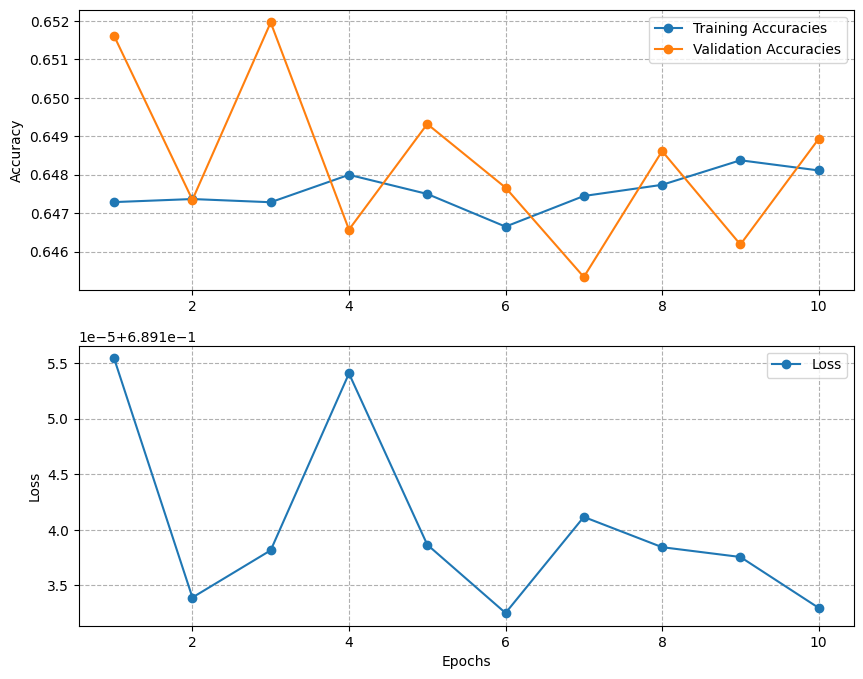

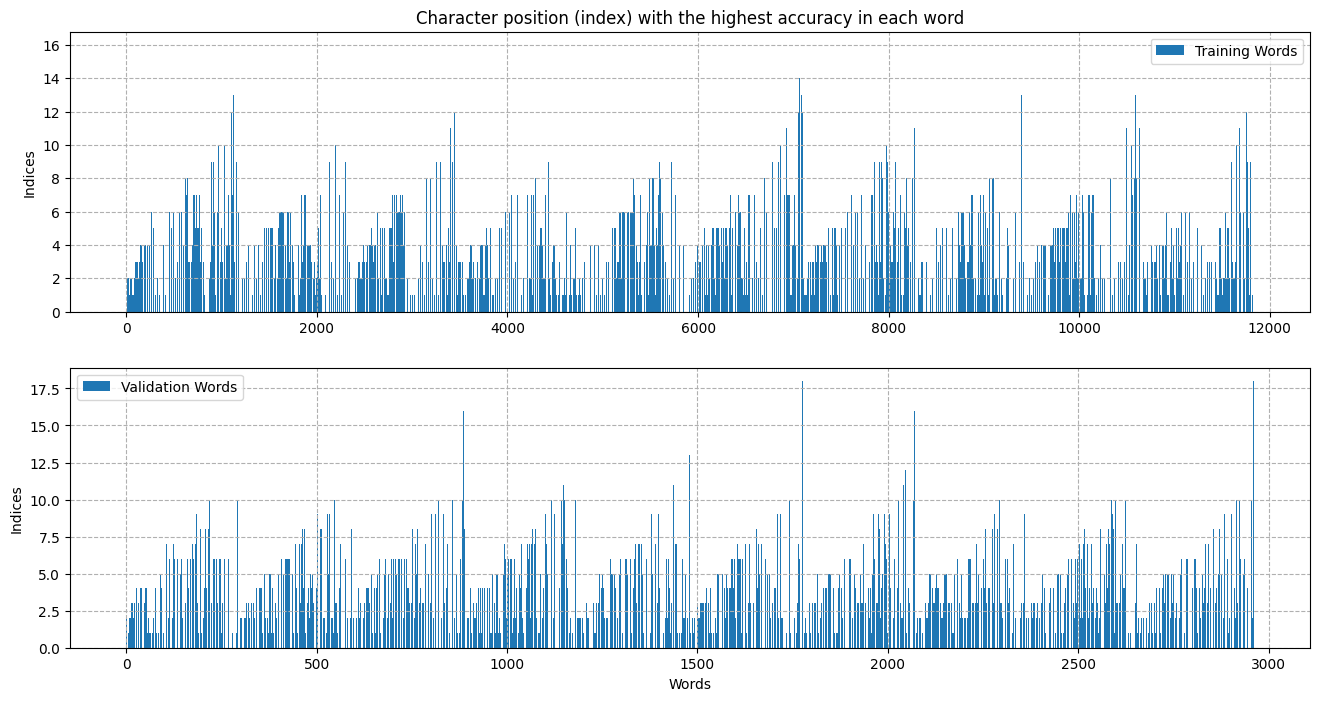

In [142]:
plot2(model.avg_train_accuracies, model.avg_valid_accuracies, model.avg_valid_losses, model.all_train_max_indecies, model.all_dev_max_indecies)